In [5]:
!pip install yfinance

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import yfinance as yf

In [8]:
# Download historical data as dataframe
data = yf.download("AAPL", start="2018-01-01", end="2023-09-01")


[*********************100%***********************]  1 of 1 completed

1 Failed download:
- AAPL: No data found for this date range, symbol may be delisted


# Informer

The Informer model variant is designed for multivariate prediction. Let's consider 'Open', 'High', 'Low', and 'Close' prices for simplicity. The provided code is designed to fetch and preprocess historical stock prices for Apple Inc. for the purpose of multivariate time series forecasting using an LSTM model. Initially, the code downloads Apple's stock data, specifically capturing four significant features: Open, High, Low, and Close prices. To make the data suitable for deep learning models, it is normalized to fit within a range of 0 to 1. The sequential data is then transformed into a format suitable for supervised learning, where the data from the past `look_back` days is used to predict the next day's features. Finally, the data is partitioned into training (67%) and test sets, ensuring separate datasets for model training and evaluation.


In [3]:
# Using multiple columns for multivariate prediction
df = data[["Open", "High", "Low", "Close"]]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df)

# Prepare data for LSTM
look_back = 10  # Number of previous time steps to use as input variables
n_features = df.shape[1]  # number of features

# Convert to supervised learning problem
X, y = [], []
for i in range(len(df_scaled) - look_back):
    X.append(df_scaled[i:i+look_back, :])
    y.append(df_scaled[i + look_back, :])
X, y = np.array(X), np.array(y)

# Reshape input to be [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], n_features))

# Train-test split
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:]
y_train, y_test = y[0:train_size], y[train_size:]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

NameError: name 'data' is not defined

# ProbSparse Self-Attention:

Self-attention involves computing a weighted sum of all values in the sequence, based on the dot product between the query and key. In ProbSparse, we don't compute this for all query-key pairs, but rather select dominant ones, thus making the computation more efficient. The given code defines a custom Keras layer, `ProbSparseSelfAttention`, which implements the multi-head self-attention mechanism, a critical component of Transformer models. This layer initializes three dense networks for the Query, Key, and Value matrices, and splits the input data into multiple heads to enable parallel processing. During the forward pass (`call` method), the Query, Key, and Value matrices are calculated, scaled, and then used to compute attention scores. These scores indicate the importance of each element in the sequence when predicting another element. The output is a weighted sum of the input values, which is then passed through another dense layer to produce the final result.


In [ ]:
class ProbSparseSelfAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, **kwargs):
        super(ProbSparseSelfAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.d_model = d_model

        # Assert that d_model is divisible by num_heads
        assert self.d_model % self.num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"

        self.depth = d_model // self.num_heads

        # Defining the dense layers for Query, Key and Value
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)

        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)

        # Fixing matrix multiplication
        matmul_qk = tf.matmul(q, k, transpose_b=True)

        d_k = tf.cast(self.depth, tf.float32)
        scaled_attention_logits = matmul_qk / tf.math.sqrt(d_k)

        attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
        output = tf.matmul(attention_weights, v)

        output = tf.transpose(output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.d_model))

        return self.dense(concat_attention)


# Informer Encoder:

The `InformerEncoder` is a custom Keras layer designed to process sequential data using a combination of attention and convolutional mechanisms. Within the encoder, the input data undergoes multi-head self-attention, utilizing the `ProbSparseSelfAttention` mechanism, to capture relationships in the data regardless of their distance. Post attention, the data is transformed and normalized, then further processed using two 1D convolutional layers, emphasizing local features in the data. After another normalization step, the processed data is pooled to a lower dimensionality, ensuring the model captures global context, and then passed through a dense layer to produce the final output.


In [ ]:
class InformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, conv_filters, **kwargs):
        super(InformerEncoder, self).__init__(**kwargs)
        self.d_model = d_model
        self.num_heads = num_heads

        # Assert that d_model is divisible by num_heads
        assert self.d_model % self.num_heads == 0, f"d_model ({d_model}) must be divisible by num_heads ({num_heads})"

        self.self_attention = ProbSparseSelfAttention(d_model=d_model, num_heads=num_heads)

        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # This dense layer will transform the input 'x' to have the dimensionality 'd_model'
        self.dense_transform = tf.keras.layers.Dense(d_model)

        self.conv1 = tf.keras.layers.Conv1D(conv_filters, 3, padding='same')
        self.conv2 = tf.keras.layers.Conv1D(d_model, 3, padding='same')
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.global_avg_pooling = tf.keras.layers.GlobalAveragePooling1D()
        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, x):
        attn_output = self.self_attention(x, x, x)

        # Transform 'x' to have the desired dimensionality
        x_transformed = self.dense_transform(x)
        attn_output = self.norm1(attn_output + x_transformed)

        conv_output = self.conv1(attn_output)
        conv_output = tf.nn.relu(conv_output)
        conv_output = self.conv2(conv_output)

        encoded_output = self.norm2(conv_output + attn_output)

        pooled_output = self.global_avg_pooling(encoded_output)
        return self.dense(pooled_output)[:, -4:]




In [ ]:
input_layer = tf.keras.layers.Input(shape=(look_back, n_features))

# Encoder
encoder_output = InformerEncoder(d_model=360, num_heads=8, conv_filters=64)(input_layer)

# Decoder (with attention)
decoder_lstm = tf.keras.layers

The `InformerModel` function is designed to create a deep learning architecture tailored for sequential data prediction. It takes an input sequence and processes it using the `InformerEncoder`, a custom encoder layer, which captures both local and global patterns in the data. Following the encoding step, a decoder structure unravels the encoded data by first repeating the encoder's output, then passing it through an LSTM layer to retain sequential dependencies, and finally making predictions using a dense layer. The resulting architecture is then compiled with the Adam optimizer and Mean Squared Error loss, ready for training on time series data.


In [ ]:
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


def InformerModel(input_shape, d_model=64, num_heads=2, conv_filters=256, learning_rate= 1e-3):
    # Input
    input_layer = Input(shape=input_shape)

    # Encoder
    encoder_output = InformerEncoder(d_model=d_model, num_heads=num_heads, conv_filters=conv_filters)(input_layer)

    # Decoder
    repeated_output = RepeatVector(4)(encoder_output)  # Repeating encoder's output
    decoder_lstm = LSTM(312, return_sequences=True)(repeated_output)
    decoder_output = Dense(4)(decoder_lstm[:, -1, :])  # Use the last sequence output to predict the next value

    # Model
    model = Model(inputs=input_layer, outputs=decoder_output)
    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')



    return model

model = InformerModel(input_shape=(look_back, n_features))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()




Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 10, 4)]           0         
                                                                 
 informer_encoder_11 (Infor  (None, 4)                 108480    
 merEncoder)                                                     
                                                                 
 repeat_vector_10 (RepeatVe  (None, 4, 4)              0         
 ctor)                                                           
                                                                 
 lstm_10 (LSTM)              (None, 4, 312)            395616    
                                                                 
 tf.__operators__.getitem_1  (None, 312)               0         
 0 (SlicingOpLambda)                                             
                                                          

The `model.fit` method trains the neural network using the provided training data (`X_train` and `y_train`) for a total of 50 epochs with mini-batches of 32 samples. During training, 20% of the training data is set aside for validation to monitor and prevent overfitting.


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.3,
    shuffle=True
)


Epoch 1/50
11/11 [==============================] - 7s 85ms/step - loss: 0.0148 - val_loss: 0.0845
Epoch 2/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0050 - val_loss: 0.0753
Epoch 3/50
11/11 [==============================] - 0s 13ms/step - loss: 0.0020 - val_loss: 0.0373
Epoch 4/50
11/11 [==============================] - 0s 13ms/step - loss: 8.5089e-04 - val_loss: 0.0167
Epoch 5/50
11/11 [==============================] - 0s 13ms/step - loss: 3.6341e-04 - val_loss: 0.0052
Epoch 6/50
11/11 [==============================] - 0s 13ms/step - loss: 3.2985e-04 - val_loss: 0.0072
Epoch 7/50
11/11 [==============================] - 0s 13ms/step - loss: 3.6485e-04 - val_loss: 0.0032
Epoch 8/50
11/11 [==============================] - 0s 14ms/step - loss: 2.5527e-04 - val_loss: 0.0014
Epoch 9/50
11/11 [==============================] - 0s 19ms/step - loss: 2.0932e-04 - val_loss: 0.0027
Epoch 10/50
11/11 [==============================] - 0s 15ms/step - loss: 2.2858e-04 

The code displays a visual representation of the model's training and validation loss over the epochs using a line chart. The x-axis represents the number of epochs, while the y-axis indicates the mean squared error, allowing users to observe how the model's performance evolves over time.


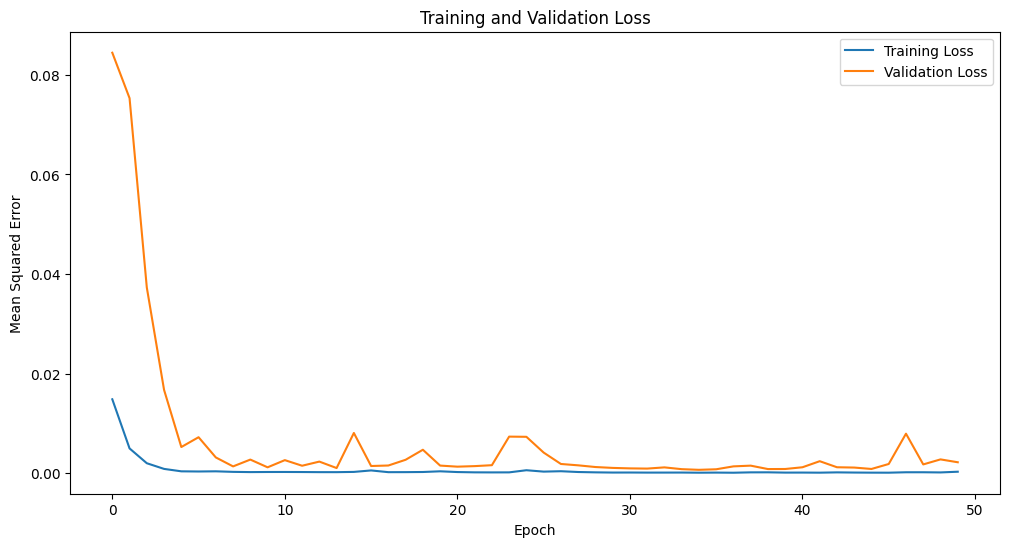

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [ ]:
test_predictions = model.predict(X_test)
test_predictions = scaler.inverse_transform(test_predictions)
true_values = scaler.inverse_transform(y_test)

mse = mean_squared_error(true_values, test_predictions)
print(f"Test MSE: {mse}")


15/15 [==============================] - 1s 3ms/step
Test MSE: 462.6375895467179


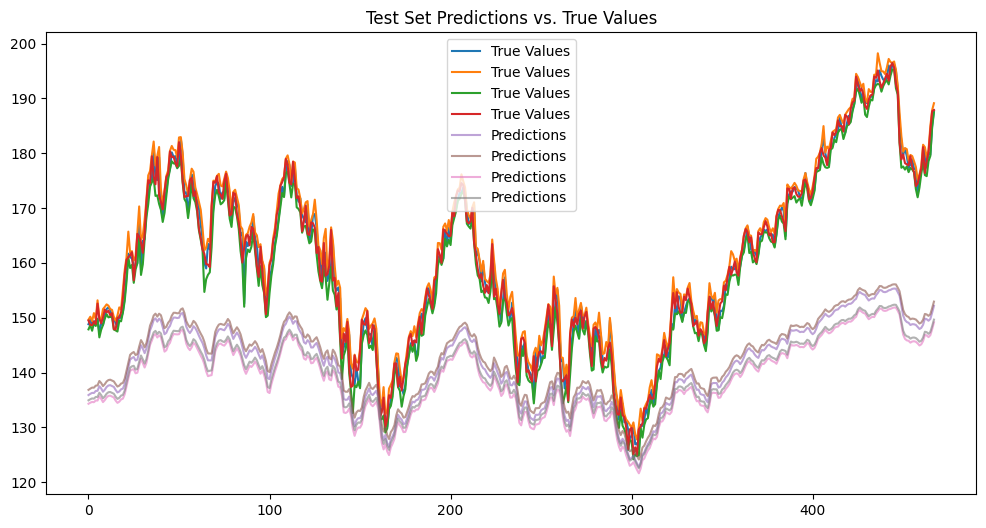

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(true_values, label='True Values')
plt.plot(test_predictions, label='Predictions', alpha=0.6)
plt.title('Test Set Predictions vs. True Values')
plt.legend()
plt.show()


In [ ]:
!pip install keras-tuner


The code defines a function to construct a neural network model using varying hyperparameters, aiming to optimize its architecture. Subsequently, the RandomSearch method from Keras Tuner is employed to explore 200 different model configurations, assessing their performance to determine the best hyperparameters that minimize the validation loss.


In [ ]:
from tensorflow.keras.layers import Input, RepeatVector, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import kerastuner as kt

def build_model(hp):
    # Input
    input_layer = Input(shape=(look_back, n_features))

    # Encoder
    encoder_output = InformerEncoder(d_model=hp.Int('d_model', min_value=32, max_value=512, step=16),
                                     num_heads=hp.Int('num_heads', 2, 8, step=2),
                                     conv_filters=hp.Int('conv_filters', min_value=16, max_value=256, step=16))(input_layer)

    # Decoder
    repeated_output = RepeatVector(4)(encoder_output)  # Repeating encoder's output
    decoder_lstm = LSTM(312, return_sequences=True)(repeated_output)
    decoder_output = Dense(4)(decoder_lstm[:, -1, :])  # Use the last sequence output to predict the next value

    # Model
    model = Model(inputs=input_layer, outputs=decoder_output)

    # Compile the model with the specified learning rate
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-2, 1e-1]))
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=30,
    executions_per_trial=5,
    directory='hyperparam_search',
    project_name='informer_model'
)

The code sets up two training callbacks: one for early stopping if validation loss doesn't improve after 10 epochs, and another to save the model weights at their best performance. With these callbacks, the tuner conducts a search over the hyperparameter space using the training data, and evaluates model configurations over 100 epochs, saving the most optimal weights and potentially halting early if improvements stagnate.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath='trial_best.h5', monitor='val_loss', verbose=1, save_best_only=True)

tuner.search(X_train, y_train,
             epochs=100,
             validation_split=0.2,
             callbacks=[early_stopping, model_checkpoint])


Trial 30 Complete [00h 00m 01s]

Best val_loss So Far: 0.0009468139498494566
Total elapsed time: 00h 30m 43s


In [ ]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Retrieve the best model
best_model = tuner.get_best_models()[0]
best_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 4)]           0         
                                                                 
 informer_encoder (Informer  (None, 4)                 108480    
 Encoder)                                                        
                                                                 
 repeat_vector (RepeatVecto  (None, 4, 4)              0         
 r)                                                              
                                                                 
 lstm (LSTM)                 (None, 4, 312)            395616    
                                                                 
 tf.__operators__.getitem (  (None, 312)               0         
 SlicingOpLambda)                                                
                                                             

In [ ]:
test_loss = best_model.evaluate(X_test, y_test)
print(f"Test MSE: {test_loss}")


15/15 [==============================] - 0s 3ms/step - loss: 0.0086
Test MSE: 0.008609036915004253


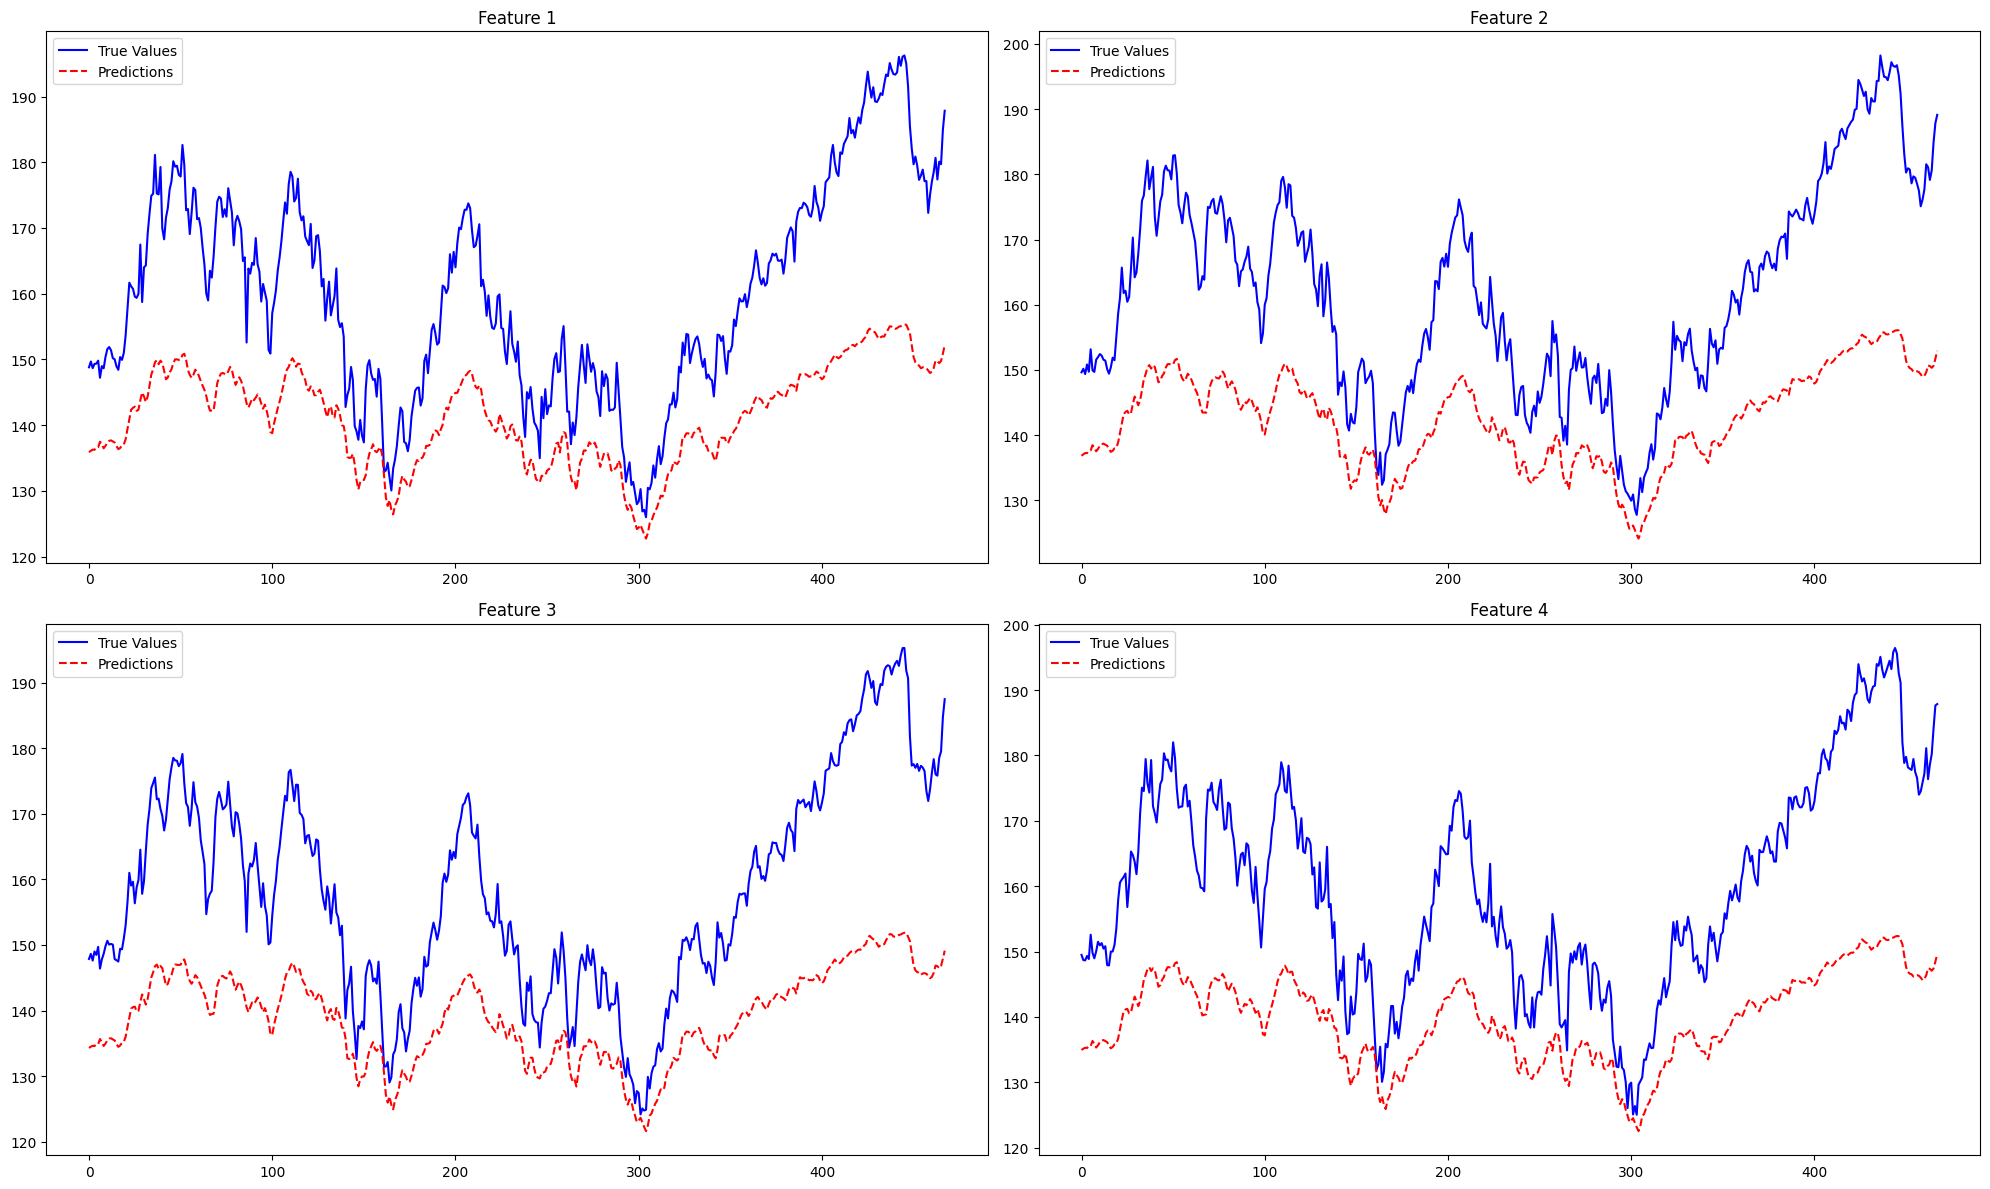

In [ ]:
plt.figure(figsize=(20, 12))
for i in range(true_values.shape[1]):
    plt.subplot(2, 2, i+1)
    plt.plot(true_values[:, i], label='True Values', color='blue')
    plt.plot(test_predictions[:, i], label='Predictions', color='red', linestyle='--')
    plt.title(f"Feature {i+1}")
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(true_values, test_predictions)
rmse = np.sqrt(test_loss)  # since loss is MSE
print(f"MAE: {mae}, RMSE: {rmse}")


MAE: 19.377517553476185, RMSE: 0.09278489594219662


In [ ]:
print(f"Best d_model: {best_hp.get('d_model')}")
print(f"Best num_heads: {best_hp.get('num_heads')}")
print(f"Best conv_filters: {best_hp.get('conv_filters')}")
print(f"Best learning_rate: {best_hp.get('learning_rate')}")


Best d_model: 64
Best num_heads: 2
Best conv_filters: 256
Best learning_rate: 0.001


In [ ]:
!pip install shap
import shap


In [ ]:
# The reference can be a dataset or just random data
background = X_train[np.random.choice(X_train.shape[0], 300, replace=False)]  # Taking a random sample of the training data as background
explainer = shap.GradientExplainer(best_model, background)


In [ ]:
shap_values = explainer.shap_values(X_test[:300])  # Computing for a subset for performance reasons


Summary plot for timestep 1


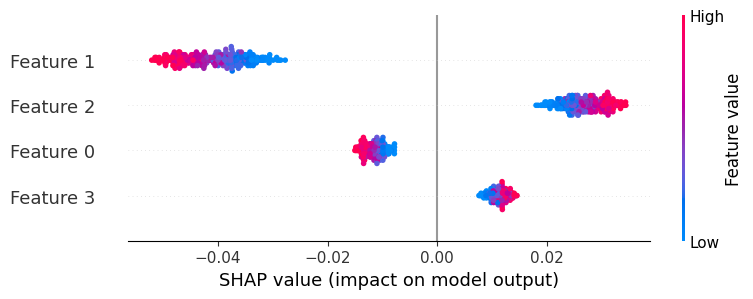

Summary plot for timestep 2


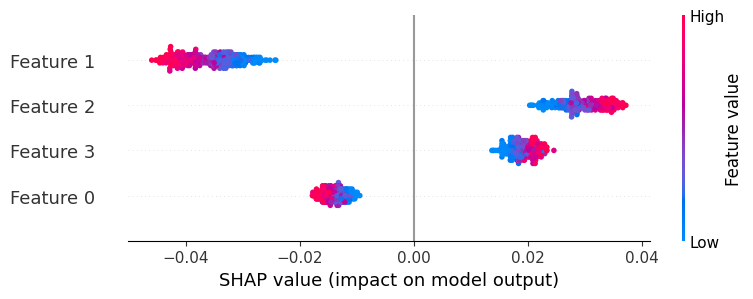

Summary plot for timestep 3


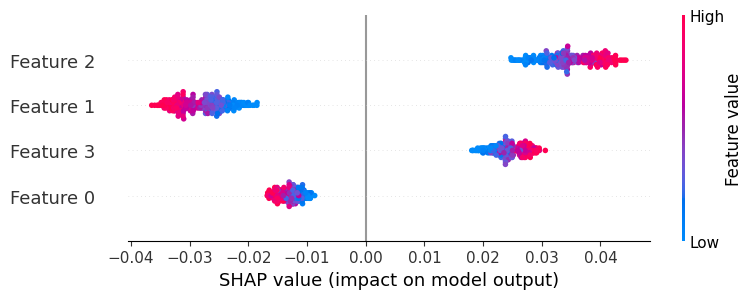

Summary plot for timestep 4


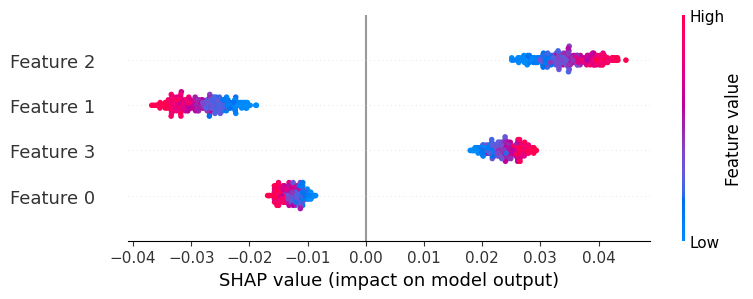

Summary plot for timestep 5


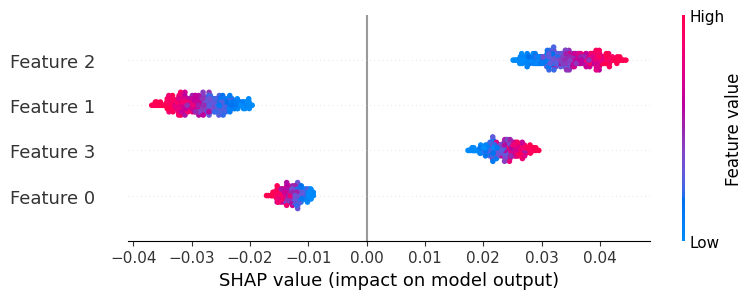

Summary plot for timestep 6


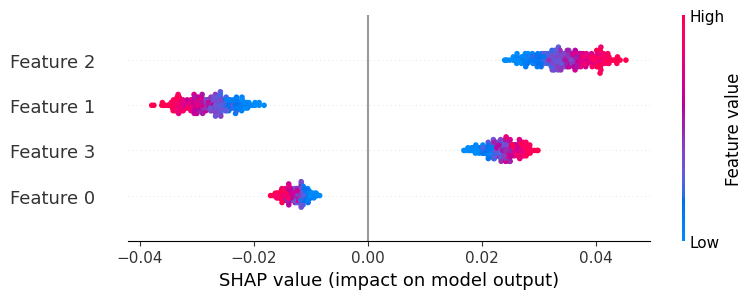

Summary plot for timestep 7


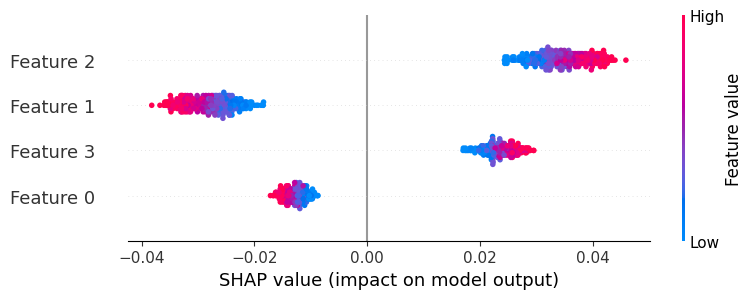

Summary plot for timestep 8


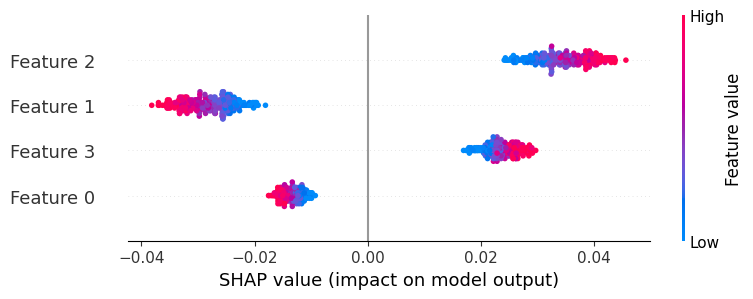

Summary plot for timestep 9


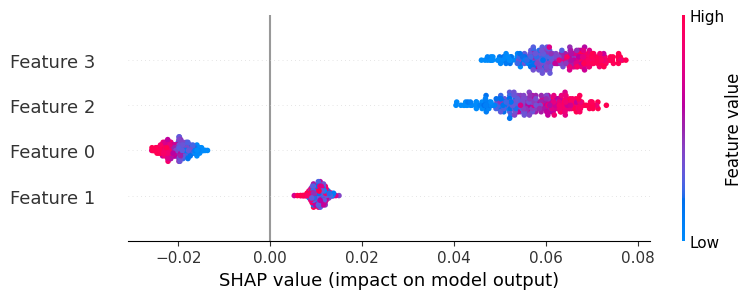

Summary plot for timestep 10


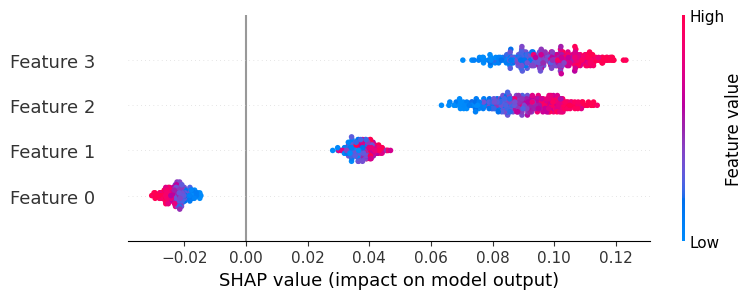

In [ ]:
for timestep in range(10):
    print(f"Summary plot for timestep {timestep + 1}")
    shap.summary_plot(shap_values[0][:, timestep, :], X_test[:300, timestep, :])


 # Shapley values

 SHAP values are indicating by how much the presence of a particular feature influenced the model's prediction, compared to if that feature was absent. The color represents the actual value of the feature itself. In the context of the present work, Shapley values are employed as a method to enhance the interpretability of the model. Shapley values provide insights into the contribution of each feature to the model's predictions. Specifically, they quantify how each feature influences the prediction by evaluating its impact when combined with all other features. By calculating Shapley values, we gain a clear understanding of the relative importance of each feature in multivariate time series prediction.

Overall, Shapley values enhance model interpretability by offering a systematic and quantitative way to dissect complex models and understand their decision-making processes. They enable us to identify which features are the key drivers of predictions, helping us make more informed decisions and potentially improving model performance. This interpretability is crucial in various applications, from finance to healthcare, where understanding the factors influencing predictions is paramount for trust and decision-making.

In [9]:
!jupyter nbconvert Multivariate_multistep_Informer.ipynb --to markdown --NbConvertApp.output_files_dir=.


[NbConvertApp] Converting notebook Multivariate_multistep_Informer.ipynb to markdown
[NbConvertApp] Support files will be in ./
[NbConvertApp] Writing 31740 bytes to Multivariate_multistep_Informer.md


In [10]:
!cat covid_analysis.md | tee -a index.md


cat: covid_analysis.md: No such file or directory


In [11]:
!cat Multivariate_multistep_Informer.md | tee -a index.md


```python
!pip install yfinance
```




```python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import yfinance as yf
```


```python
# Download historical data as dataframe
data = yf.download("AAPL", start="2018-01-01", end="2023-09-01")

```

    [*********************100%***********************]  1 of 1 completed
    
    1 Failed download:
    - AAPL: No data found for this date range, symbol may be delisted


# Informer

The Informer model variant is designed for multivariate prediction. Let's consider 'Open', 'High', 'Low', and 'Close' prices for simplicity. The provided code is designed to fetch and preprocess historical stock prices for Apple Inc. for the purpose of multivariate time series forecasting using an LSTM model. Initially, the code downloads Apple's stock data, specifically capturing four significant features: Open, High, Low,

In [12]:
!rm Multivariate_multistep_Informer.md
